In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import re

In [2]:
def extract_dataset_name(path: str) -> str:
    # Get the folder name right after "logs/"
    folder_name = os.path.basename(os.path.dirname(path))
    # Remove the trailing timestamp (matches "_YYYY-MM-DD_HH-MM-SS")
    dataset_name = re.sub(r'_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}$', '', folder_name)
    return dataset_name

In [13]:
# Path to the CSV file
csv_path = "logs/S_Curve_2025-08-18_10-47-23/prdc_all_regs_steps.csv"
save_dir = os.path.dirname(csv_path)
dataset_name = extract_dataset_name(csv_path) # Load CSV
df = pd.read_csv(csv_path)
# Display first few rows
df.head()


,reg,step,precision,recall,density,coverage
0,0.0,0,0.0114 ± 0.0145,0.9741 ± 0.0661,0.0086 ± 0.0111,0.0442 ± 0.0511
1,0.0,1000,0.9547 ± 0.0140,0.9976 ± 0.0022,0.9150 ± 0.0264,0.9394 ± 0.0243
2,0.0,2000,0.9701 ± 0.0102,0.9984 ± 0.0009,0.9412 ± 0.0229,0.9550 ± 0.0108
3,0.0,3000,0.9823 ± 0.0043,0.9975 ± 0.0015,0.9640 ± 0.0161,0.9574 ± 0.0072
4,0.0,4000,0.9786 ± 0.0043,0.9973 ± 0.0012,0.9545 ± 0.0142,0.9611 ± 0.0059


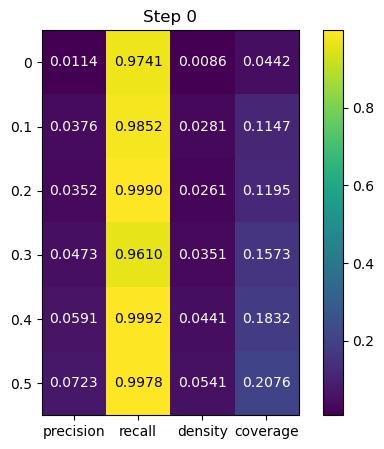

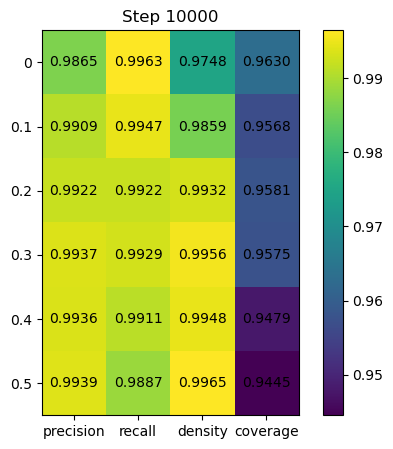

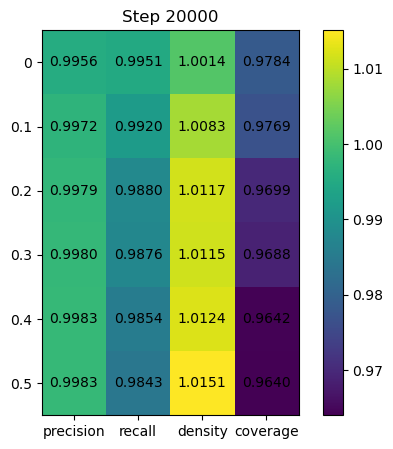

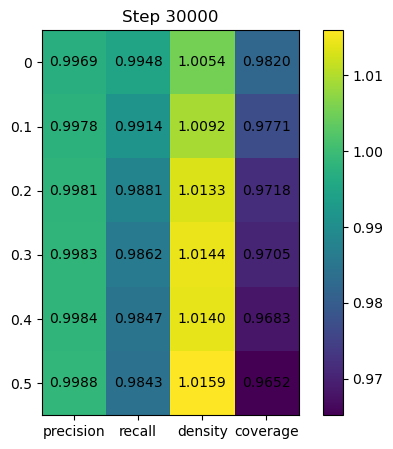

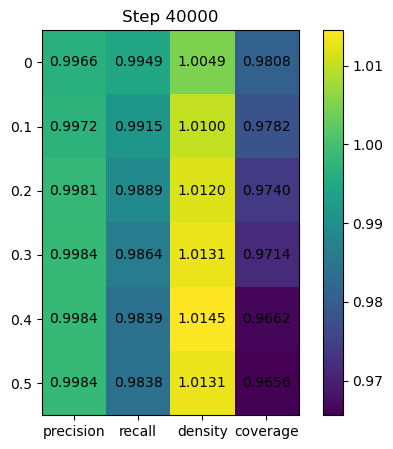

In [14]:
step_values = [0, 10000, 20000, 30000, 40000]
regs_to_show = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

metrics = ['precision', 'recall', 'density', 'coverage']

for step_value in step_values:
    summary = df[df['step'] == step_value]
    summary = summary[summary['reg'].isin(regs_to_show)]
    summary = summary.drop(columns=['step']).reset_index(drop=True)

    # Extract mean values
    values = []
    for col in metrics:
        mean_vals = summary[col].str.split(' ± ', expand=True)[0].astype(float).to_numpy()
        values.append(mean_vals)
    values = np.array(values).T  # shape: (len(regs_to_show), 4)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Heatmap with reg on y-axis, metrics on x-axis
    im = ax.imshow(values, cmap="viridis")

    # Set ticks
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_yticks(np.arange(len(regs_to_show)))
    ax.set_xticklabels(metrics)
    ax.set_yticklabels(regs_to_show)

    # Add text annotations
    for i in range(values.shape[0]):        # reg values (rows)
        for j in range(values.shape[1]):    # metrics (cols)
            ax.text(j, i, f"{values[i, j]:.4f}",
                    ha="center", va="center",
                    color="white" if values[i, j] < values.max()/2 else "black")

    ax.set_title(f"Step {step_value}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Save as PNG
    out_path = os.path.join(save_dir, f"heatmap_step_{step_value}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()


In [15]:
regs_to_plot = [0, 0.5]  # change as needed

# Filter dataframe for selected regs
plot_df = df[df['reg'].isin(regs_to_plot)].copy()

metrics = ['precision', 'recall', 'density', 'coverage']


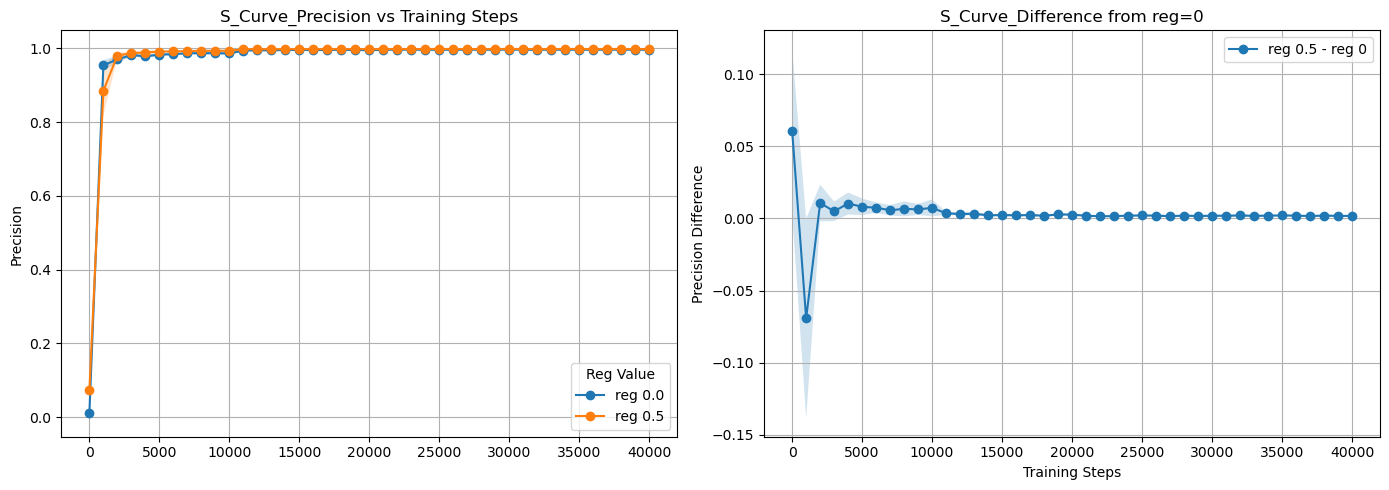

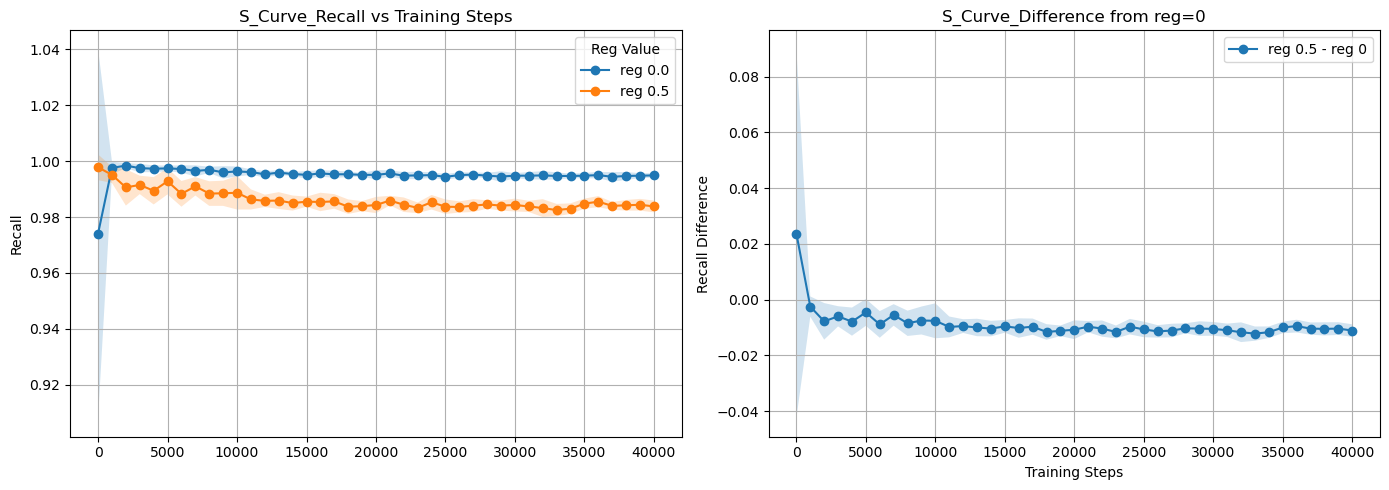

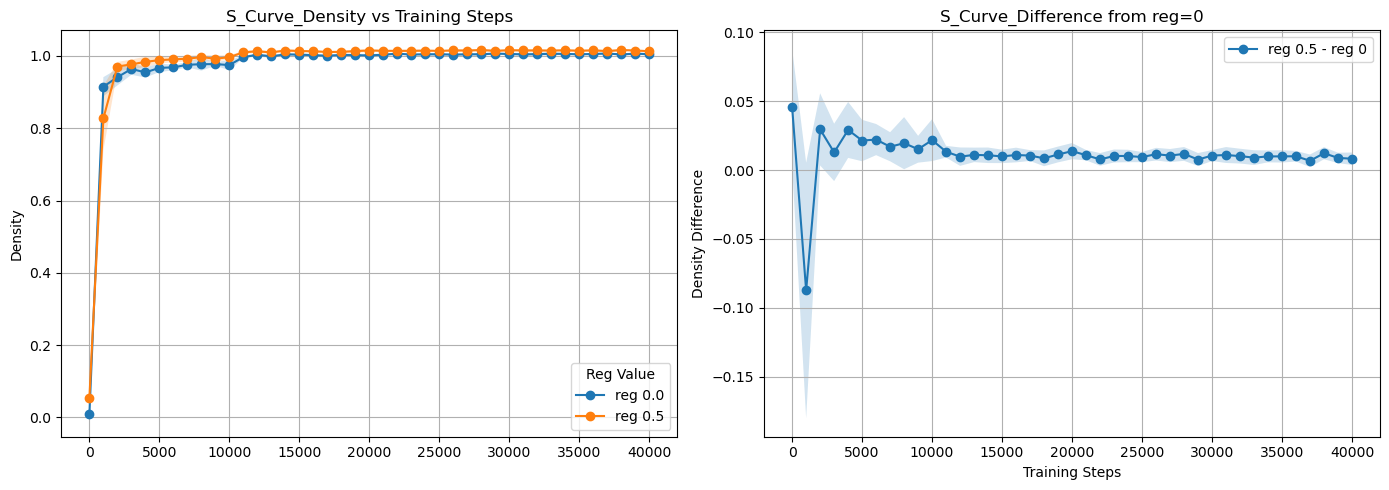

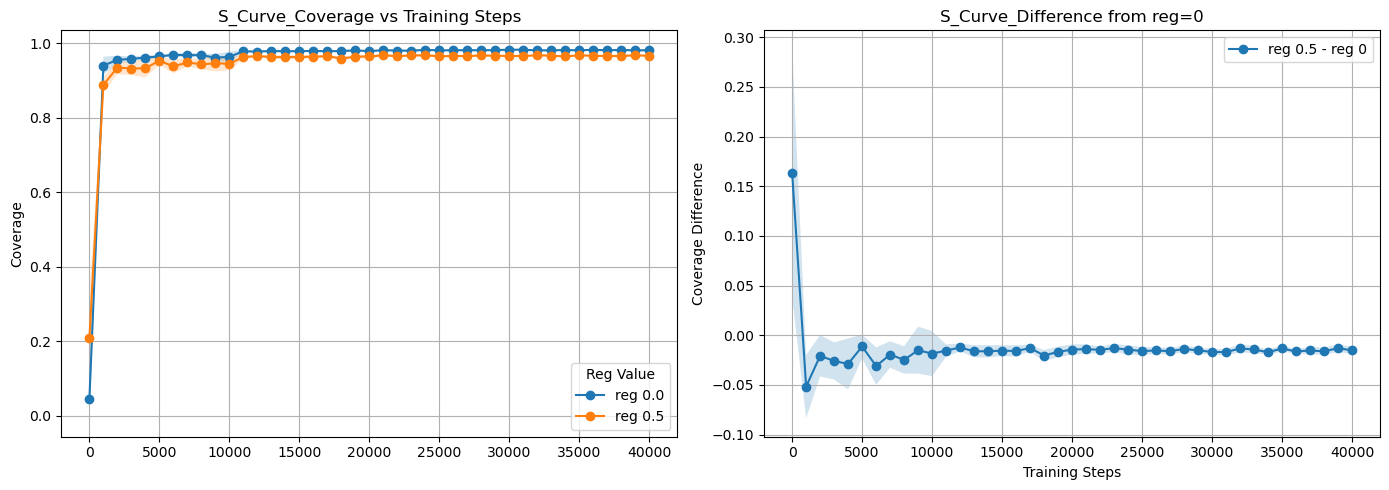

In [16]:
# Split ± std into numeric columns for all metrics
for metric in metrics:
    plot_df[[f'{metric}_mean', f'{metric}_std']] = plot_df[metric].str.split(' ± ', expand=True)
    plot_df[f'{metric}_mean'] = plot_df[f'{metric}_mean'].astype(float)
    plot_df[f'{metric}_std'] = plot_df[f'{metric}_std'].astype(float)

# Plot each metric
for metric in metrics:
    baseline = plot_df[plot_df['reg'] == 0]
    others = plot_df[plot_df['reg'] != 0]

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    # Left: original metric curves with ± std shading
    for reg_val in plot_df['reg'].unique():
        reg_data = plot_df[plot_df['reg'] == reg_val]
        axs[0].plot(reg_data['step'], reg_data[f'{metric}_mean'], marker='o', label=f'reg {reg_val}')
        axs[0].fill_between(reg_data['step'], 
                            reg_data[f'{metric}_mean'] - reg_data[f'{metric}_std'], 
                            reg_data[f'{metric}_mean'] + reg_data[f'{metric}_std'], 
                            alpha=0.2)
    axs[0].set_ylabel(metric.capitalize())
    axs[0].set_title(f'{dataset_name}_{metric.capitalize()} vs Training Steps')
    axs[0].grid(True)
    axs[0].legend(title='Reg Value')

    # Right: difference from baseline (reg=0) with ± std propagation
    for reg_val in others['reg'].unique():
        reg_data = others[others['reg'] == reg_val]
        diff = reg_data[f'{metric}_mean'].values - baseline[f'{metric}_mean'].values
        diff_std = np.sqrt(reg_data[f'{metric}_std'].values**2 + baseline[f'{metric}_std'].values**2)
        axs[1].plot(reg_data['step'], diff, marker='o', label=f'reg {reg_val} - reg 0')
        axs[1].fill_between(reg_data['step'], diff - diff_std, diff + diff_std, alpha=0.2)
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel(f'{metric.capitalize()} Difference')
    axs[1].set_title(f'{dataset_name}_Difference from reg=0')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/{dataset_name}_{metric.capitalize()}.png", dpi=300)
    plt.show()